<a href="https://colab.research.google.com/github/pharringtonp19/housing-and-homelessness/blob/main/notebooks/JudgeIV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Import Libraries**

In [51]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from functools import partial
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### **Parameters**

In [52]:
d = 10
n = 1000
j = 2
key = jax.random.PRNGKey(0)

In [53]:
def Moved(foreclosed, features, key):
  scalar = 0.1*foreclosed + jnp.sum(features)
  probs = jax.nn.sigmoid(scalar)
  y = jax.random.bernoulli(key, p=probs).astype(jnp.float32)
  return y

In [54]:
def sample(d, leniency, key):
  k1, k2 = jax.random.split(key)
  features = jax.random.normal(key, shape=(d,))
  scalar =  leniency + 0.3*jnp.sum(features)
  probs = jax.nn.sigmoid(scalar)
  d = jax.random.bernoulli(key, p=probs).astype(jnp.float32)
  y = Moved(d, features, k2)
  return y, d, features

sample(d, 0.5, key)

(Array(1., dtype=float32),
 Array(1., dtype=float32),
 Array([-0.3721109 ,  0.26423115, -0.18252768, -0.7368197 , -0.44030377,
        -0.1521442 , -0.67135346, -0.5908641 ,  0.73168886,  0.5673026 ],      dtype=float32))

In [55]:
def simulate_cluster(d, j, n, key):
  k1, k2 = jax.random.split(key)
  ls = jax.random.uniform(k1, minval=0.3, maxval=0.7, shape=(j,))
  ls = jnp.repeat(ls, n // j)
  y, d, x = jax.vmap(sample, in_axes=(None, 0, 0))(d, ls, jax.random.split(k2, n))
  y, d = y.reshape(-1,1), d.reshape(-1,1)
  regs1 = jnp.hstack((jnp.ones_like(d), x))
  dhat = regs1 @ jnp.linalg.lstsq(regs1, d)[0]
  regs2 = jnp.hstack((dhat, jnp.ones_like(d), x))
  return jnp.linalg.lstsq(regs2, y)[0][0]

In [56]:
def simulate_iid(d, n, key):
  k1, k2 = jax.random.split(key)
  ls = jax.random.uniform(k1, minval=0.3, maxval=0.7, shape=(n,))
  y, d, x = jax.vmap(sample, in_axes=(None, 0, 0))(d, ls, jax.random.split(k2, n))
  y, d = y.reshape(-1,1), d.reshape(-1,1)
  regs1 = jnp.hstack((jnp.ones_like(d), x))
  dhat = regs1 @ jnp.linalg.lstsq(regs1, d)[0]
  regs2 = jnp.hstack((dhat, jnp.ones_like(d), x))
  return jnp.linalg.lstsq(regs2, y)[0][0]

In [57]:
f_cluster = partial(simulate_cluster, d, j, n)
results_cluster = jax.vmap(f_cluster)(jax.random.split(key, 1000))

In [58]:
f_iid = partial(simulate_iid, d, n)
results_iid = jax.vmap(f_iid)(jax.random.split(key, 1000))

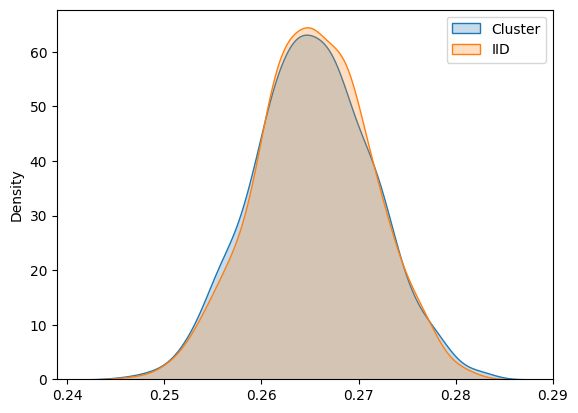

In [59]:


# Assuming results_cluster and results_iid are arrays or lists of data
sns.kdeplot(results_cluster.reshape(-1,), label="Cluster", shade=True)
sns.kdeplot(results_iid.reshape(-1,), label="IID", shade=True)

# Add labels and show plot
plt.legend()
plt.show()